# Visualize key recovery with rejection sampling on BIKE
This notebook guides the reader through the process of validating the attack in *"Don't Reject This: Key-Recovery Timing Attacks Due to Rejection-Sampling in HQC and BIKE"*.

It is structured as a step by step analysis of data files generated by various executions of `oqs-afw`. Please see the [README.md](../README.md) for instructions on how to build and execute the binary.

## Preliminary info on `oqs-afw`

Most of the commands refered to by this notebook require some pre-generated plaintexts with a distinguishing feature called $\theta$ (see the paper for more information). This $\theta$ represents the number of iterations in the inner loop of the rejection sampling algorithm.

These plaintexts are already stored in the sqlite database `rejections-sampling-plaintexts.db` in the repo root.

It's possible to generate your own database of plaintexts (or simply append some more on top of the existing ones). See 

    cargo run --release -- attack rejection-sampling collect-plaintexts --help

for how to do that. 

**NOTE!** When the output of oqs-afw refers to 'iterations' it is actually providing the number $S_E*1000 +\theta$ where $S_E$ is the number of seed expansions recorded. This is a side effect of the implementation.

# Step 0. Setting up the python environment

In [2]:
#writetofile = "../tmp-output/"
writetofile = None

import matplotlib
if writetofile:
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "lualatex",
        'font.family': 'serif',
        "font.serif": ['Computer Modern Roman'],
        "font.sans-serif": ['Computer Modern Sans Serif'],
        "font.monospace": ['Computer Modern Typewriter'],
        'text.usetex': True,
        'pgf.rcfonts': False
    })



import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.animation import FuncAnimation
from IPython import display
import numpy as np
import pandas as pd
import seaborn as sns
import os
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')  # Use '' for auto, or force e.g. to 'en_US.UTF-8'

sns.set_theme(style='darkgrid', font="serif", rc={
    'legend.frameon':True,
})

def plt_show(outputname="output.pgf", w=2.25, h=2.25):
    if writetofile:
        fname = os.path.join(writetofile, outputname)
        plt.gcf().set_size_inches(w=w, h=h)
        plt.savefig(fname, bbox_inches="tight")
        print("Output printed to " + fname)
    else:
        plt.show()
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()

## Step 1. Generate and read data files for $\theta$ timings

For this step to work you will need to run this in as close to noise free environment as practical. That means turning off as many processes as possible, turing off hyper threading and turbo boost and setting the sceduling governor (if running linux) to 'performance'.

To generate your own timing measurments (1M samples) execute the following command from the root directory of this repository:

    #!/bin/sh
    export NUM_SAMPLES=1000000
    cargo run --release -- attack rejection-sampling iteration-timings --db rejection-sampling-plaintexts.db --destination data/compressed/bike-l1/bike-l1-timings-$NUM_SAMPLES.csv.gz -m $NUM_SAMPLES bike kem-l1

Then execute the cell below (make sure NUM_SAMPLES matches the value above):

In [12]:
NUM_SAMPLES=1000000

bikedata = pd.read_csv(f"../data/compressed/bike-l1/bike-l1-timings-{NUM_SAMPLES}.csv.gz")
bikedata.columns = ["Algorithm", "Num. Seedexpansions", "Num. PRNG Samplings $\\theta$", "Clock cycles"]

# comment to disable: filtering out unreliable \theta's with low number of pre-generated plaintexts
bikedata = bikedata[(bikedata["Num. PRNG Samplings $\\theta$"] >= 140) & (bikedata["Num. PRNG Samplings $\\theta$"] <= 242)]
bikedata.reset_index(inplace=True, drop=True)

bikedata

,Algorithm,Num. Seedexpansions,Num. PRNG Samplings $\theta$,Clock cycles
0,BikeL1,35,140,2686845
1,BikeL1,35,140,2698820
2,BikeL1,35,140,2679006
3,BikeL1,35,140,2697467
4,BikeL1,35,140,2670384
...,...,...,...,...
102999995,BikeL1,61,242,2687832
102999996,BikeL1,61,242,2693641
102999997,BikeL1,61,242,2675402
102999998,BikeL1,61,242,2673643


# Step 2. Plot BIKE Timings
Run this cell to generate figure 6 in the paper (this might take up to 5-10 minutes or so, if there are many samples in the data set)

dataalg: BikeL1


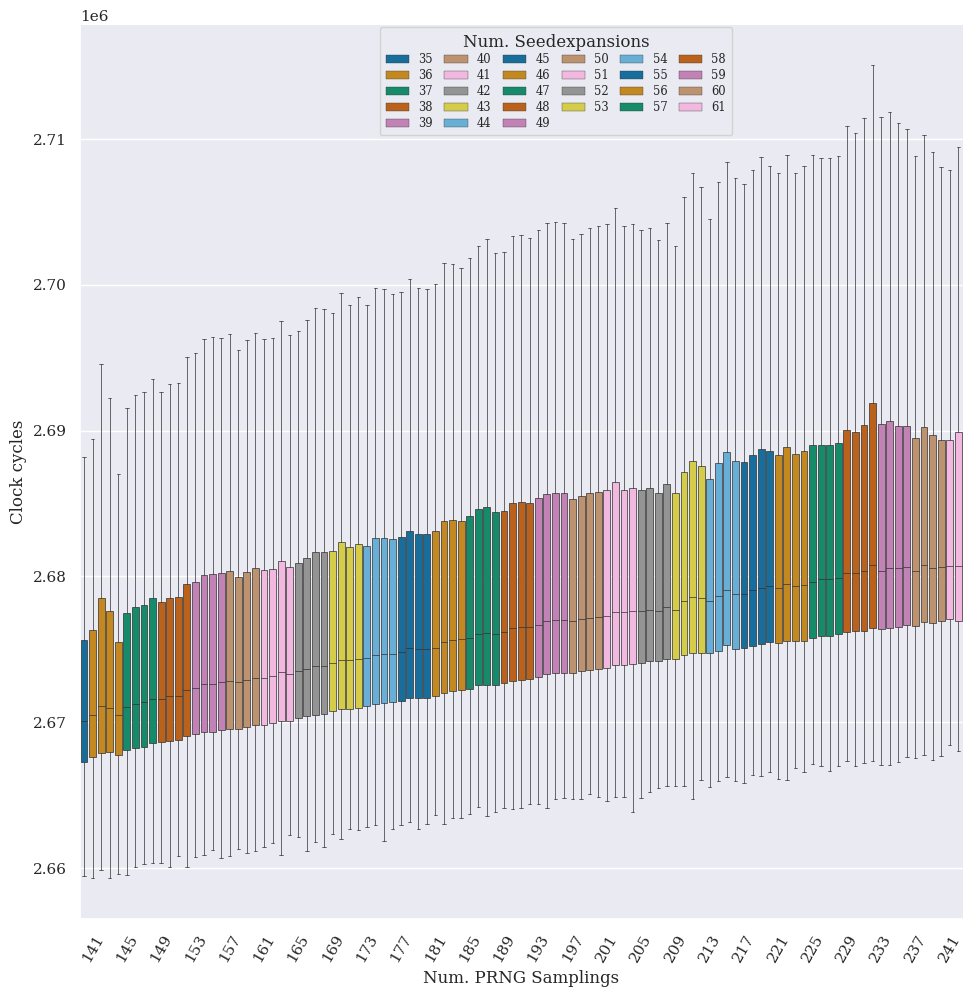

<Figure size 640x480 with 0 Axes>

In [13]:
for data in [bikedata]:
    dataalg = data["Algorithm"][0]
    print("dataalg: " + dataalg)
    g = sns.catplot(
        data=data,
        orient="v",
        x="Num. PRNG Samplings $\\theta$",
        y="Clock cycles",
        hue="Num. Seedexpansions",
        dodge=False,
        kind="box",
        showfliers=False,
        sharex=True,
        sharey=True,
        palette="colorblind",
        linewidth=0.5,
        aspect=1,
        height=10,
        whis=1.5
    )
    for axes in g.axes.flat:
        xticks = axes.get_xticklabels()
        if dataalg == "BikeL1":
            for xtick in xticks:
                label = int(xtick.get_text())
                if label % 4 != 1: # the first tick in a new seedexpansion
                    xtick.set_text("")
        axes.set_xticklabels(xticks, rotation=60)
        axes.ticklabel_format(axis="y", scilimits=[-1, 1])
        axes.set(xlabel="Num. PRNG Samplings")
    sns.move_legend(g, loc="upper center", bbox_to_anchor=(0.485, 0.97), ncol=6, fontsize="x-small", frameon=True, borderpad=0.5, labelspacing=0.25, columnspacing=1.0)
    if dataalg == "BikeL1":
        w = 5.37502
        h = 3
    else:
        w = 3
        h = 2
    plt_show("{}-timings.pgf".format(dataalg), w=w, h=h)


## Step 2.1. Lock closer at the timing distributions for some select $\theta$'s
Not included in paper

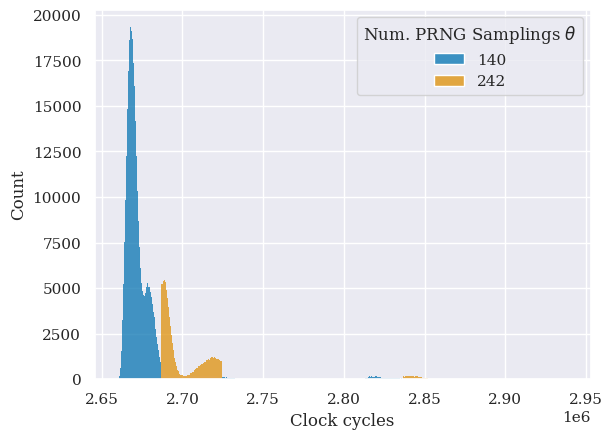

<Figure size 640x480 with 0 Axes>

In [14]:
timing_distribution_of = [140, 242] # or whatever \theta's you wish to compare in the previous picture

filtered_timing_data = bikedata[(bikedata["Num. PRNG Samplings $\\theta$"].isin(timing_distribution_of))]
filtered_timing_data = filtered_timing_data[filtered_timing_data["Clock cycles"] <= 3000000]
sns.histplot(data=filtered_timing_data, x="Clock cycles", multiple="dodge", hue="Num. PRNG Samplings $\\theta$",
        palette="colorblind",)
plt_show("filtered_timing_data.pgf")

# Step 3. $\theta$ distribution data
This data was recorded when the pre-generated plaintexts were collected. If these numbers are to be updated, please see the notes in the introduction of this notebook. The hard coded data comes from copy-pasting (and some formatting) the final output of the plaintext collection command

This data corresponds to figure 5 of the paper.

In [5]:

bikehistdata = [
#[35,138,1],
#[35,139,9],
[35,140,38],
[36,141,162],
[36,142,802],
[36,143,2839],
[36,144,10563],
[37,145,34424],
[37,146,104103],
[37,147,291491],
[37,148,765680],
[38,149,1888311],
[38,150,4392169],
[38,151,9682582],
[38,152,20300457],
[39,153,40581803],
[39,154,77575004],
[39,155,142145846],
[39,156,250255003],
[40,157,424213861],
[40,158,693414743],
[40,159,1095205861],
[40,160,1673625091],
[41,161,2478452739],
[41,162,3561295650],
[41,163,4971442063],
[41,164,6749961845],
[42,165,8923760740],
[42,166,11498337998],
[42,167,14454129957],
[42,168,17741006831],
[43,169,21280189138],
[43,170,24964453190],
[43,171,28663354931],
[43,172,32232436960],
[44,173,35523694068],
[44,174,38393584471],
[44,175,40717618086],
[44,176,42396466535],
[45,177,43364110541],
[45,178,43592191467],
[45,179,43089501005],
[45,180,41901555125],
[46,181,40101226257],
[46,182,37787996178],
[46,183,35073861477],
[46,184,32079622703],
[47,185,28922228409],
[47,186,25713157913],
[47,187,22550517370],
[47,188,19514676526],
[48,189,16669015393],
[48,190,14058764123],
[48,191,11710718520],
[48,192,9637236005],
[49,193,7837148005],
[49,194,6299774194],
[49,195,5006618510],
[49,196,3935031333],
[50,197,3059284504],
[50,198,2353274929],
[50,199,1791334463],
[50,200,1349740982],
[51,201,1006813057],
[51,202,743708444],
[51,203,544064129],
[51,204,394323251],
[52,205,283088783],
[52,206,201432340],
[52,207,142049089],
[52,208,99298182],
[53,209,68811128],
[53,210,47288715],
[53,211,32222709],
[53,212,21786627],
[54,213,14612471],
[54,214,9726257],
[54,215,6421062],
[54,216,4205677],
[55,217,2734006],
[55,218,1767204],
[55,219,1131071],
[55,220,720350],
[56,221,454602],
[56,222,286302],
[56,223,176943],
[56,224,110118],
[57,225,67036],
[57,226,41538],
[57,227,25143],
[57,228,15162],
[58,229,9034],
[58,230,5381],
[58,231,3269],
[58,232,1873],
[59,233,1123],
[59,234,651],
[59,235,385],
[59,236,186],
[60,237,144],
[60,238,67],
[60,239,46],
[60,240,22],
[61,241,10],
[61,242,10],
#[61,243,4],
#[61,244,1],
#[62,245,1],
#[62,247,1],
]

bikehistdata = pd.DataFrame(bikehistdata, columns=["Num. Seedexpansions", "Num. PRNG Samplings $\\theta$", "Num. Plaintexts"])

bikehistsum = bikehistdata['Num. Plaintexts'].sum()
bikehistsubfracbelow = 160
bikehistsubfrac = bikehistdata[bikehistdata["Num. PRNG Samplings $\\theta$"] <= bikehistsubfracbelow]['Num. Plaintexts'].sum() / bikehistsum
bikehisttopfracabove = 200
bikehisttopfrac = bikehistdata[bikehistdata["Num. PRNG Samplings $\\theta$"] >= bikehisttopfracabove]['Num. Plaintexts'].sum() / bikehistsum
# mean = np.average(mids, weights=n)
bikehistmean = np.average(bikehistdata["Num. PRNG Samplings $\\theta$"], weights=bikehistdata["Num. Plaintexts"])
# var = np.average((mids - mean)**2, weights=n)
bikehistvar = np.average((bikehistdata["Num. PRNG Samplings $\\theta$"] - bikehistmean)**2, weights=bikehistdata["Num. Plaintexts"])
# std = np.sqrt(var)
bikehiststd = np.sqrt(bikehistvar)

print("Sum: " + str(bikehistsum))
print("average: " + str(bikehistmean))
print("Variance: " + str(bikehistvar))
print("Std deviation: " + str(bikehiststd))
print("Fraction below {} (span {}): {}".format(bikehistsubfracbelow, bikehistsubfracbelow - bikehistdata["Num. PRNG Samplings $\\theta$"].min(), bikehistsubfrac))
print("Fraction above {} (span {}): {}".format(bikehisttopfracabove, bikehistdata["Num. PRNG Samplings $\\theta$"].max() - bikehisttopfracabove, bikehisttopfrac))

bikehistdata#, hqchistdata

Sum: 840010665564
average: 178.64167951360724
Variance: 59.514328773464236
Std deviation: 7.714553050790709
Fraction below 160 (span 20): 0.005279088724453985
Fraction above 200 (span 42): 0.005925096886309468


,Num. Seedexpansions,Num. PRNG Samplings $\theta$,Num. Plaintexts
0,35,140,38
1,36,141,162
2,36,142,802
3,36,143,2839
4,36,144,10563
...,...,...,...
98,60,238,67
99,60,239,46
100,60,240,22
101,61,241,10


## 3.1 plot it

This generates figure 5 of the paper.

dataalg: bike


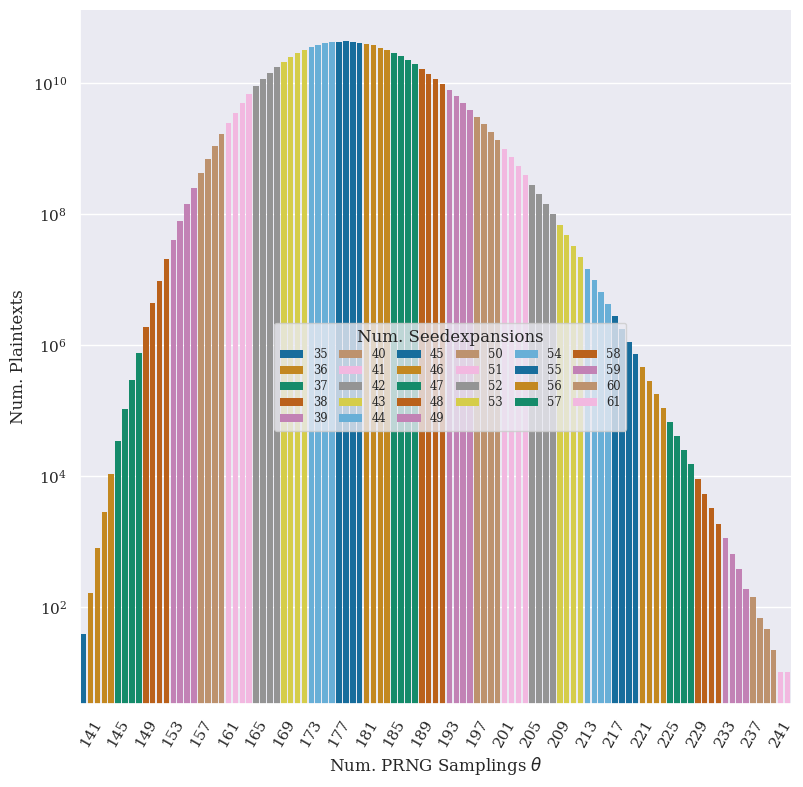

<Figure size 640x480 with 0 Axes>

In [6]:
for (dataalg, histdata) in [("bike", bikehistdata)]:
    print("dataalg: " + dataalg)
    g = sns.catplot(
        data=histdata,
        order=range(histdata['Num. PRNG Samplings $\\theta$'].min(),histdata['Num. PRNG Samplings $\\theta$'].max()+1),
        x="Num. PRNG Samplings $\\theta$",
        hue="Num. Seedexpansions",
        y="Num. Plaintexts",
        kind="bar",
        palette="colorblind",
        linewidth=0,
        dodge= (dataalg != "bike"),
        height=8
    )
    g.ax.set_yscale('log')

    for axes in g.axes.flat:
        xticks = axes.get_xticklabels()
        if dataalg == "bike":
            for xtick in xticks:
                label = int(xtick.get_text())
                if label % 4 != 1: # the first tick in a new seedexpansion
                    xtick.set_text("")
        axes.set_xticklabels(xticks, rotation=60)
    if dataalg == "bike":
        loc = "center"
        bbox_to_anchor=(0.45, 0.5)
    else:
        loc="upper center"
        bbox_to_anchor=(0.45, 0.97)
    sns.move_legend(g, loc=loc, bbox_to_anchor=bbox_to_anchor, ncol=6, fontsize="x-small", frameon=True, borderpad=0.5, labelspacing=0.25, columnspacing=1.0)
    plt_show("{}-iter-hist.pgf".format(dataalg), w=5.37502, h=3)

# Step 4. Prepare the BIKE attack simulation

In order to verify the attack we need to cheat and compare against the ground truth.

The first step is to generate a keypair. This is done automatically by oqs-afw at need, but for comparison and visualization we also need the distance spectrum of the secret key. We can generate both with the following command:

    cargo run --release -- attack rejection-sampling bike-distance-spectrum --destination data/compressed/bike-l1/kem-l1.keypair.ds --key-file data/compressed/bike-l1/kem-l1.keypair --create-key-if-missing kem-l1

In [4]:
bikefacit = pd.read_csv("../data/compressed/bike-l1/kem-l1.keypair.ds")[["distance", "count"]]
bikefacit.columns = ["distance", "Multip."]
bikefacit

,distance,Multip.
0,0,0
1,1,1
2,2,1
3,3,0
4,4,1
...,...,...
6158,6158,0
6159,6159,0
6160,6160,0
6161,6161,0


# Step 5. Run the attack simulation

## Step 5.1 attack preliminaries
The actual attack can be run with the following command:

    cargo run --release -- attack rejection-sampling bike-attack --chain-length 100000 --db rejection-sampling-plaintexts.db --hamming-weight 149 --epsilon 0.01 --destination data/compressed/bike-l1/kem-l1-hw149-100000-ep0.01-00.csv.gz --threads=4 --reuse-key-pair data/compressed/bike-l1/kem-l1.keypair kem-l1

This runs the attack simulation with an IDEAL oracle (see paper). The ideal oracle is then wrapped with an error rate (epsilon argument) of 0.01. This matches empirical results with a real-world timing timing-based distinguisher. This can be reproduced with the following command (must run in as close to noise free environment as possible):

    cargo run --release -- attack rejection-sampling bike-eval-distinguisher --delta-iter 22 --hamming-weight 157 --num-decaps 1000 --num-profiling 1000 --db rejection-sampling-plaintexts.db --trials 10000 kem-l1

Note that the hamming weight is set to 157 here, which gives us roughly the same DFR when comparing against the amplification attack used in the simulation (which uses HW of 149).

## Step 5.2. Run the full simulation

A helper script by name [run-incremental-bike-attack.sh](../scripts/run-incremental-bike-attack.sh) is provided to generate a bunch of simulation runs, which when combined below will contain enough data to visualize the attack's success. This script can be interrupted and resumed. Only partial simulation data will be lost but already completed simulation results will be retained.

Remember to run the script with repo root as current working directory.

## Step 5.3. Read the data files

Run the cell below to load the data files. Edit `NUM_100K` to change the number of data files to load

In [8]:
NUM_100K = 85

path_fmt = "../data/compressed/bike-l1/kem-l1-hw149-100000-ep0.01-{:02d}.csv.gz"

def read_csv(idx):
    f = path_fmt.format(idx)
    #print(f"reading {f}")
    df = pd.read_csv(f)
    df["dataset"] = idx
    df = df.merge(bikefacit, on="distance")
    # Remove the zero'th distance
    df = df[df["distance"] != 0]
    return df

bikedata = read_csv(0)
for i in range(1, NUM_100K):
    try:
        bikedata = pd.concat([bikedata, read_csv(i)])
    except:
        print(f"Stopped reading files at index {i}: Not found")
        break
else:
    print(f"Finished reading {NUM_100K} data files")

aggbikedata = bikedata[bikedata["list"].isin(["f","g"])].groupby(["distance", "Multip."], as_index=False).sum()
aggbikedata

Finished reading 85 data files


,distance,Multip.,count,dataset
0,1,1,404182,7140
1,2,1,403480,7140
2,3,0,410441,7140
3,4,1,403723,7140
4,5,1,404062,7140
...,...,...,...,...
6156,6157,1,405071,7140
6157,6158,0,411700,7140
6158,6159,0,410540,7140
6159,6160,0,410280,7140


## Step 5.4. Scatterplot and histogram

Run the following cell to generate figure 7 of the paper. Colours ('hue') are selected by "cheating" i.e. by knowing the real multiplicities of the secret key (Step 4, above). In a real attack the multiplicities are determined by partitioning the graph into (most likely) 4 distinct sections. Each data point corresponds to a specific distance that is present this many times in the distance spectrum of the secret key. We refer to the AsiaCrypt 16 [1] article for calculating the secret key from the distance spectrum. Note that the journal version [2] of the same article can also handle some errors in the distance spectrum and still calculate the correct secret key.

[1] Qian Guo, Thomas Johansson, and Paul Stankovski. A key recovery attack
on MDPC with CCA security using decoding errors. In Jung Hee Cheon and
Tsuyoshi Takagi, editors, ASIACRYPT 2016, Part I, volume 10031 of LNCS,
pages 789–815. Springer, Heidelberg, December 2016

[2] Qian Guo, Thomas Johansson, and Paul Stankovski Wagner. A key recovery
reaction attack on QC-MDPC. IEEE Trans. Inf. Theory, 65(3):1845–1861,
2019.

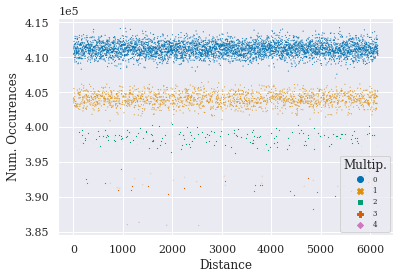

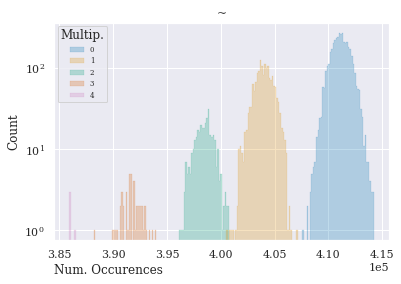

<Figure size 432x288 with 0 Axes>

In [9]:
axis = sns.scatterplot(data=aggbikedata, x="distance", y="count", hue="Multip.", style="Multip.", edgecolor=None, s=1, palette="colorblind")
axis.set(
   xlabel="Distance",
   ylabel="Num. Occurences",
)
axis.ticklabel_format(axis="y", scilimits=[-1, 1])
sns.move_legend(axis, "lower right", fontsize="x-small")
plt_show("bike-distance-spectrum.pgf", w=2.25)

axis = sns.histplot(data=aggbikedata, x="count", hue="Multip.", log_scale=(False, True), bins=200, element="step", linewidth=0.1, palette="colorblind", legend=True)
axis.set_xlabel("Num. Occurences", loc="left")
axis.set_ylabel("Count")
axis.set_title("~")
axis.ticklabel_format(axis="x", scilimits=[-1, 1])
sns.move_legend(axis, "upper left", fontsize="x-small")
plt_show("bike-distance-histogram.pgf", w=2.25)